# Metadata

```
Course:  DS 5001
module:  03 
topic:   Entropy and Term Length
author:  R.C. Alvarado
date:    12 Dec 2021

purpose: This notebook explores the relationship between term length and entropy.
```

# Set Up

## Config

In [1]:
data_home = '../data'
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']

## Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px

In [3]:
sns.set()

## Import Data

In [4]:
K = pd.read_csv(f"{data_home}/output/austen-combo-TOKENS.csv").set_index(OHCO)
V = pd.read_csv(f"{data_home}/output/austen-combo-VOCAB.csv").set_index('term_str')

# Add some features for this analysis
V['s'] = 1 / V.p

In [5]:
# K.head()

In [8]:
V.head()

,n,n_chars,p,i,h,s
term_str,,,,,,
1,3,1,0.000015,16.058922,0.000235,68268.0
15,1,2,0.000005,17.643884,0.000086,204804.0
16,1,2,0.000005,17.643884,0.000086,204804.0
1760,1,4,0.000005,17.643884,0.000086,204804.0
1784,1,4,0.000005,17.643884,0.000086,204804.0


# Vocab $V$

## Corpus frequency of terms

Some words are very high frequency, but the vast majority have very low frequencies. We will explore the significane of this difference in the next module.

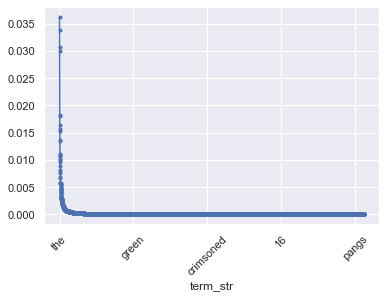

In [7]:
V.p.sort_values(ascending=False).plot(style='.-', rot=45);

## Frequency of frequencies

The same data, but looked at in terms of the distribition of probabilities. This is so that it can be compared to the following graphs of $s$, $i$, and $h$.

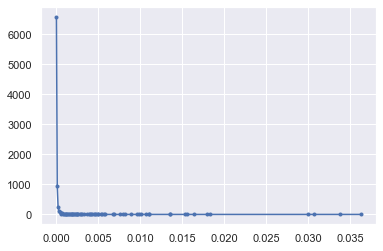

In [9]:
V.p.round(4).value_counts().sort_index().plot(style='.-');

# Chiasmus Structure of $p$, $s$, $i$, and $h$

$ \Large p \rightarrow s = 1/p \rightarrow i = log(s) \rightarrow h = p i$ 

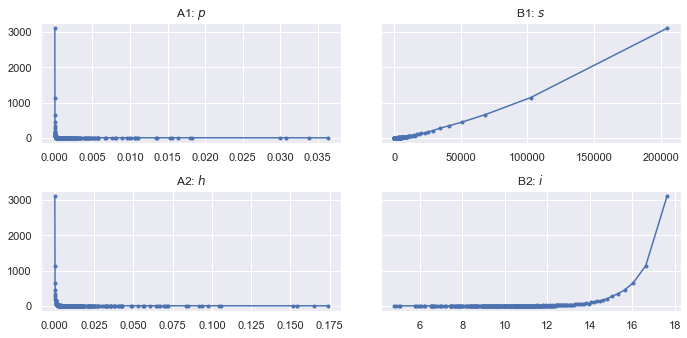

In [10]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,5), sharey='row')
fig.tight_layout(pad=2)
V.p.value_counts().sort_index().plot(style='.-', ax=axes[0,0], title="A1: $p$") 
V.s.value_counts().sort_index().plot(style='.-', ax=axes[0,1], title="B1: $s$")
V.i.value_counts().sort_index().plot(style='.-', ax=axes[1,1], title="B2: $i$") 
V.h.value_counts().sort_index().plot(style='.-', ax=axes[1,0], title="A2: $h$");

Note the range of $i$: it is on the same order as the range of `n_chars`.

# Compare $L$ to $p$, $s$, $i$, and $h$ over types and tokens

Now let's look at how these four features relate to term length $L$, the number of characters in a term (`n_chars`)

## Create a dataframe for $L$

In [9]:
VG = V.groupby('n_chars')

In [13]:
# Distribution of L over the vocabulary (types)
L = VG.n.count().to_frame('v_n')
L['v_p'] = L.v_n / L.v_n.sum()
L['v_s'] = 1 / L.v_p
L['v_i'] = np.log2(L.v_s)
L['v_h'] = L.v_p * L.v_i

# Distribution of L over the corpus (tokens)
L['k_n'] = VG.n.sum()
L['k_p'] = L.k_n / L.k_n.sum()
L['k_s'] = 1 / L.k_p
L['k_i'] = np.log2(L.k_s)
L['k_h'] = L.k_p * L.k_i

# Aggregate probability features over tokens
for func in ['sum','mean']:
    for x in 'psih':
        L[f"k{func}_{x}"] = VG[x].agg(func)    
        
# L.index.name = 'n_chars'        
L.columns = pd.Index([tuple(col.split('_')) for col in L.columns])
L.T.index.names = ['pop','stat']
Lnorm = (L - L.mean()) / L.std()

In [22]:
# L.style.background_gradient(cmap='YlGnBu')

In [26]:
# L['v'].style.background_gradient(cmap='YlGnBu')

In [27]:
# L['k'].style.background_gradient(cmap='YlGnBu')

## $L$ distributions over Types and Tokens

Compare corpus (token) and vocab (type) frequencies. Why are the distributions different?

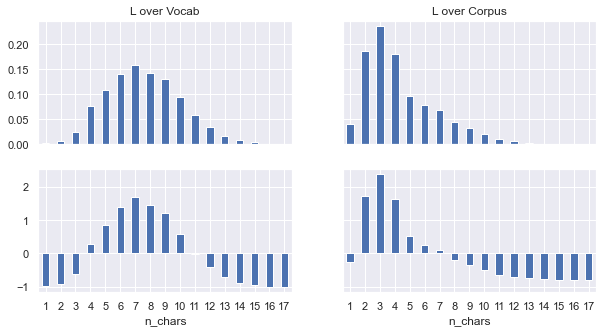

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey='row', figsize=(10,5))
L.v.p.plot.bar( ax=axes[0,0], title='L over Vocab')
L.k.p.plot.bar( ax=axes[0,1], title='L over Corpus')
Lnorm.v.p.plot.bar( ax=axes[1,0], rot=0)
Lnorm.k.p.plot.bar( ax=axes[1,1], rot=0);

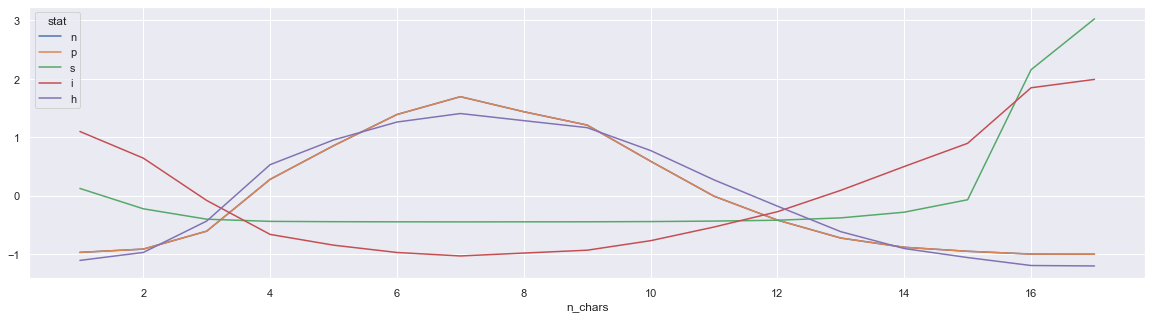

In [15]:
Lnorm.v.plot(figsize=(20,5));

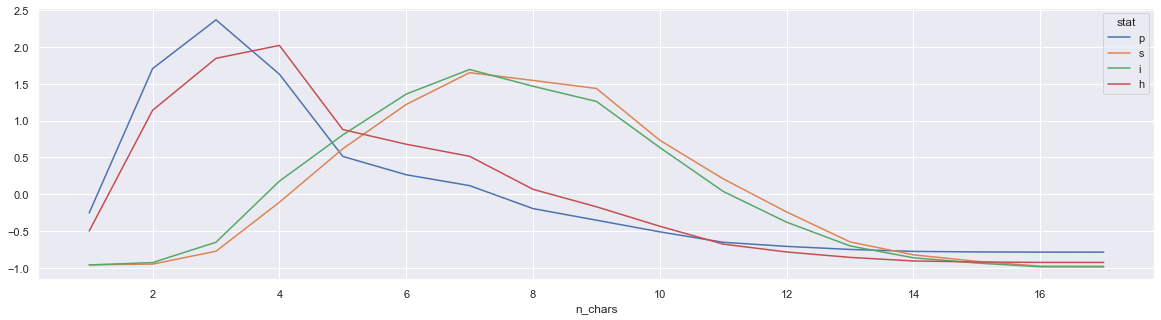

In [16]:
Lnorm.ksum.plot(figsize=(20,5));

**NOTE:** Notice how easy it is to combare features in the shaded table vs the chart.

In [40]:
V.corr().stack().to_frame('c').loc[('n_chars','i')]

c    0.290317
Name: (n_chars, i), dtype: float64

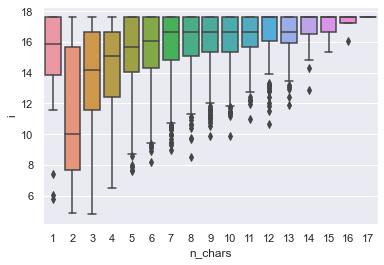

In [36]:
sns.boxplot(data=V.reset_index(), x='n_chars', y='i');

## Plot All

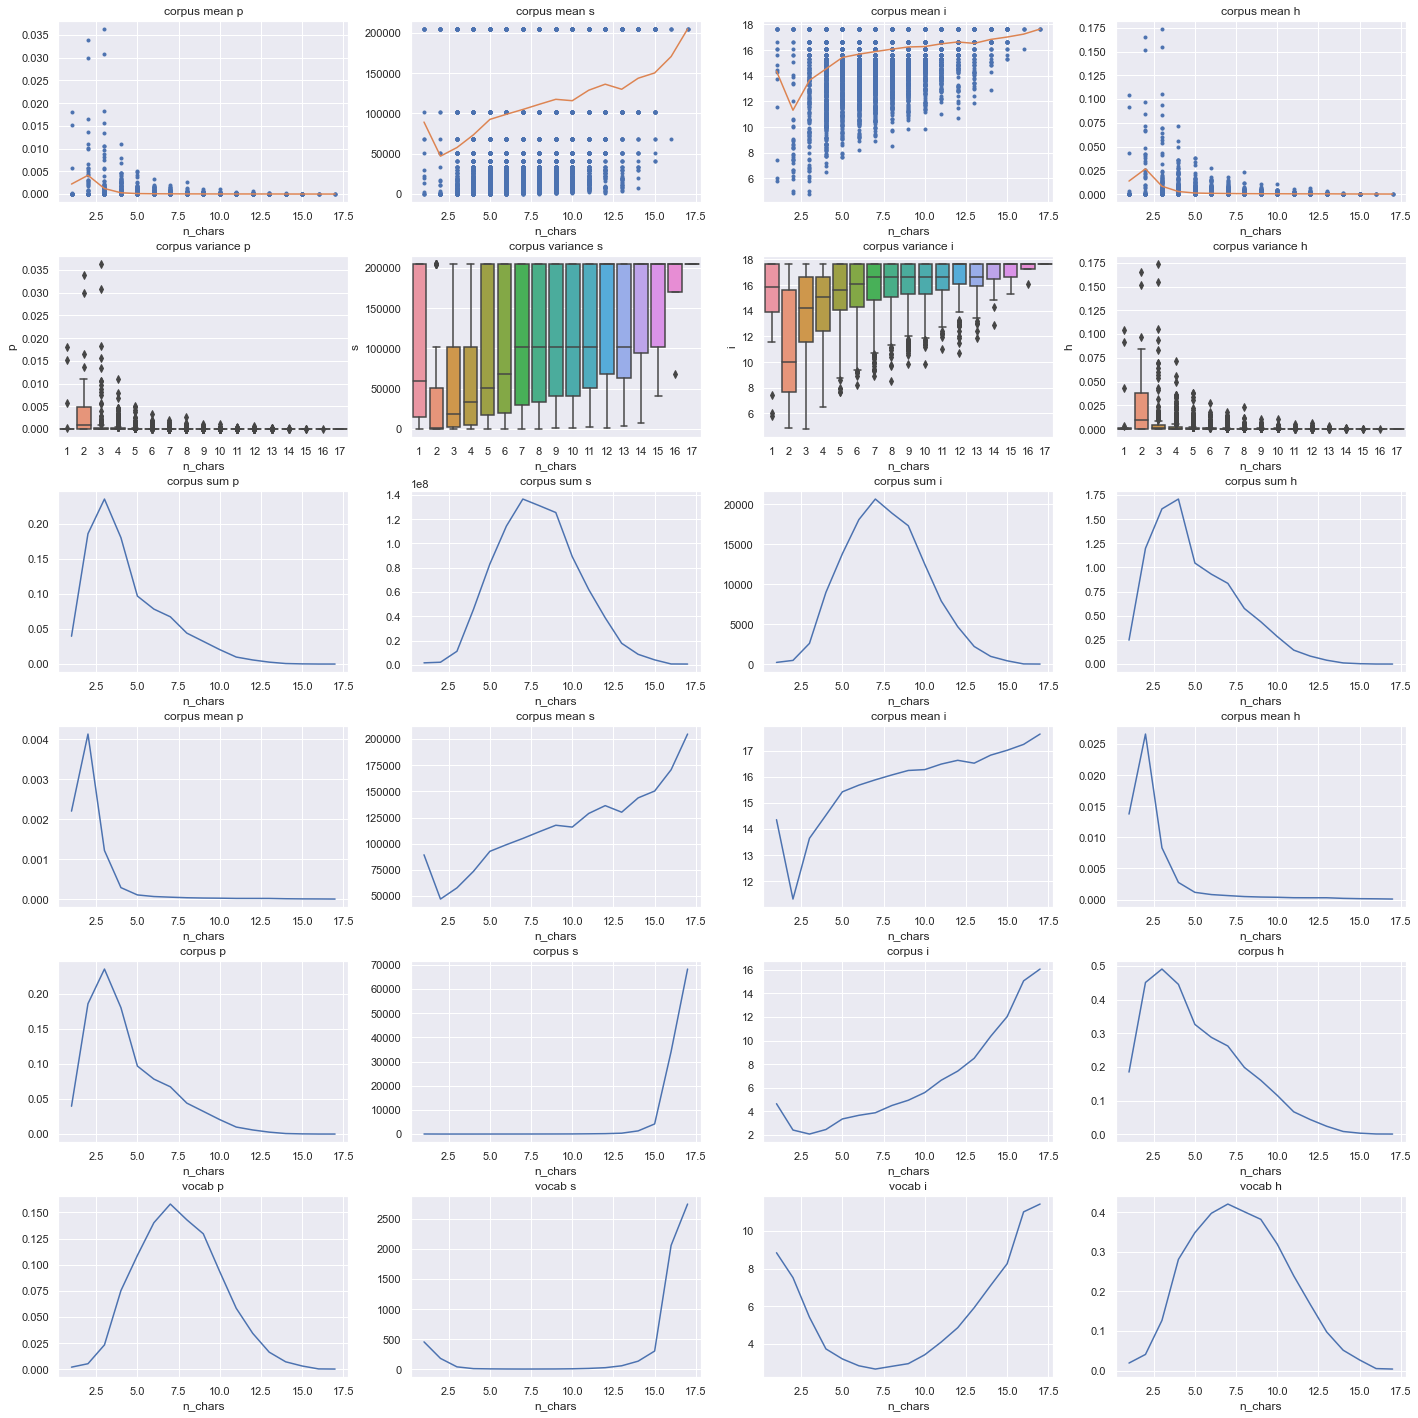

In [28]:
fig, axes = plt.subplots(ncols=4, nrows=6, figsize=(20,20), sharex=False)
fig.tight_layout(pad=2.5)
for i, x in enumerate(list("psih")):
    
#     ax = axes[0, i]
    
#     # Counts 
#     V[x].value_counts().plot(style='*-', ax=ax)
#     ax.set_title(f"${x}$")    

    ax = axes[0, i]
    
    # Means and points
    V.plot('n_chars', x, style='.', ax=ax, legend=False)
    L.kmean[x].plot(ax=ax);
    ax.set_title(f'corpus mean {x}')

    ax = axes[1, i]
    
    # Variances 
    sns.boxplot(data=V.reset_index(), x='n_chars', y=x, ax=ax)
    ax.set_title(f'corpus variance {x}')

    ax = axes[2, i]

    # Ksum
    L.ksum[x].plot(ax=ax)
    ax.set_title(f'corpus sum {x}')
    
    ax = axes[3, i]
    
    # Kmean
    L.kmean[x].plot(ax=ax)
    ax.set_title(f"corpus mean {x}")

    ax = axes[4, i]
    
    # K
    L.k[x].plot(ax=ax)
    ax.set_title(f"corpus {x}")

    ax = axes[5, i]
    
    # V
    L.v[x].plot(ax=ax)
    ax.set_title(f"vocab {x}")


In [29]:
def plot_chiasmus(df, kind='bar'):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,6), sharex=True)
    fig.tight_layout()
    df.p.plot(kind=kind, ax=axes[0,0], title='P')
    df.s.plot(kind=kind, ax=axes[0,1], title='S')
    df.i.plot(kind=kind, ax=axes[1,1], title='I', rot=0)
    df.h.plot(kind=kind, ax=axes[1,0], title='H', rot=0)

In [19]:
# plot_chiasmus(Lnorm.v, 'bar')

In [20]:
# plot_chiasmus(Lnorm.k, 'bar')

In [21]:
# plot_chiasmus(Lnorm.ksum, 'bar')

In [22]:
# plot_chiasmus(Lnorm.kmean, 'bar')

# Conclusions

* All high frequency, low information terms are short.
* Average term length increase with information.
* Information and term length in fact have the same scale! They are weakly correlated; $0.3$ 
  * Characters as units of information.
* $s$ or $i$ can be used to cull significant terms.
* The bulk of surprise is in the seven letter words. 
  * Does this mean that the vocabulary frequency of character length is short cut to computing the entropy of character length types?

# Explore Term Length Vector Space 

Can we learn anything about the structure of our corpus from distribution of term lengths? If information is related to length, there must be something to observe.

In [26]:
import sys; sys.path.append('../lib')
from hac import HAC

In [27]:
K['n_chars'] = K.term_str.str.len()

In [28]:
T1 = K.groupby(OHCO[:2]+['n_chars']).n_chars.count().unstack(fill_value=0)

T2 = (T1.T / T1.T.sum()).T

T3 = T2.corr().stack().sort_values().to_frame('c')
T3.index.names = ['x','y']
T3 = T3[T3.apply(lambda x: x.name[0] > x.name[1], 1)]
T3 = T3.sort_values('c', ascending=False)

## Book 1 (SS)

In [40]:
T1.loc[1, 5:].style.background_gradient(axis=1)

n_chars,5,6,7,8,9,10,11,12,13,14,15,16,17
chap_num,,,,,,,,,,,,,
1,166,128,106,99,54,32,22,9,2,3,0,0,0
2,196,139,133,87,51,32,20,10,4,0,0,0,0
3,143,112,108,93,51,35,20,18,9,1,0,0,0
4,191,164,133,84,74,48,24,19,9,3,0,0,0
5,107,69,66,58,38,25,17,6,3,2,1,0,0
6,160,106,101,66,40,23,13,10,3,0,0,0,0
7,137,98,77,73,61,30,17,9,6,0,0,0,0
8,106,85,102,59,55,20,14,8,6,1,0,1,0
9,195,123,129,118,56,34,21,9,4,0,0,0,0


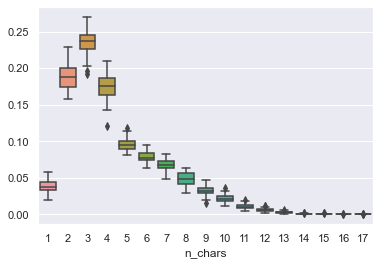

In [30]:
sns.boxplot(data=T2.loc[1]);

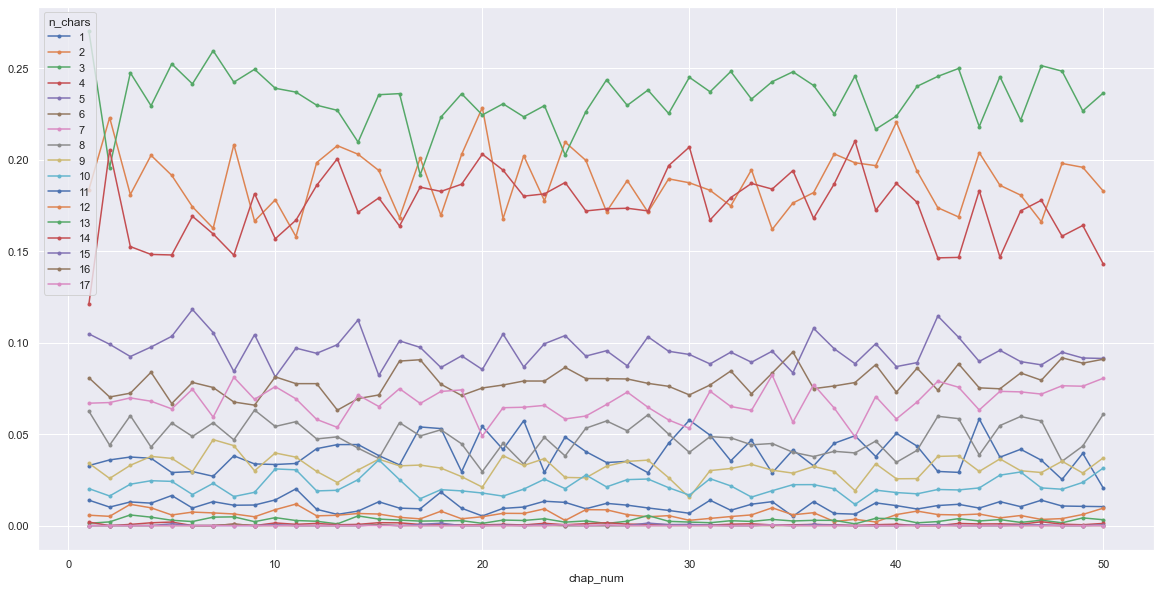

In [31]:
T2.loc[1, 1:].plot(figsize=(20,10), style='.-');

<Figure size 432x288 with 0 Axes>

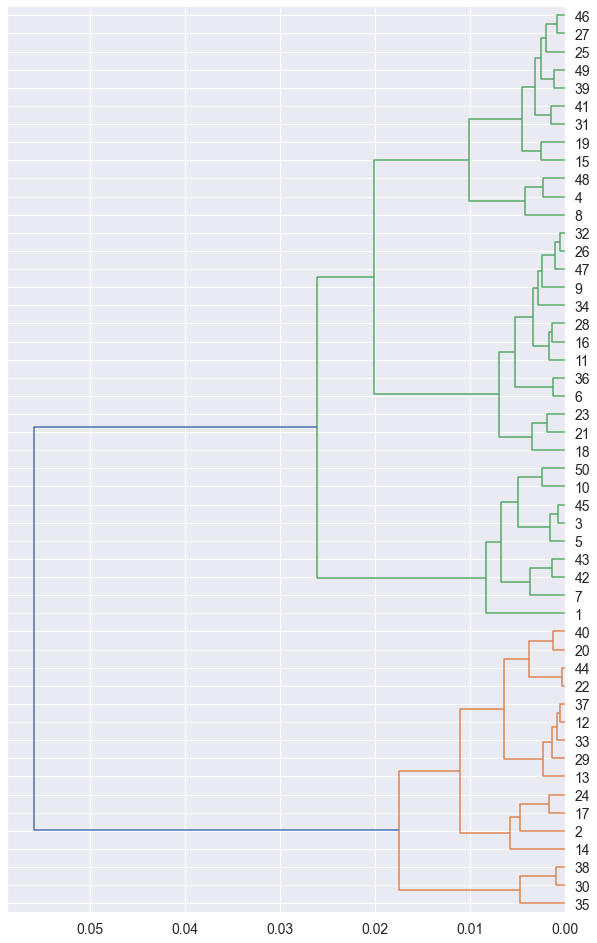

In [32]:
HAC(T2.loc[1]).plot()

## Book 2 (P)

In [33]:
T1.loc[2, 5:].style.background_gradient(axis=1)

n_chars,5,6,7,8,9,10,11,12,13,14,15,16,17
chap_num,,,,,,,,,,,,,
1,291,223,155,142,102,59,28,23,8,6,3,0,0
2,215,157,135,98,81,42,21,19,10,2,2,0,0
3,285,237,190,123,97,42,28,10,10,2,1,0,0
4,184,138,137,88,63,63,25,17,5,3,4,0,0
5,334,261,198,127,114,66,33,17,6,1,1,0,0
6,405,259,243,170,129,62,33,28,13,1,0,1,0
7,378,234,207,111,113,42,22,20,5,2,0,0,0
8,344,237,210,132,109,55,22,16,10,4,1,0,0
9,261,239,230,103,127,62,22,15,5,1,0,0,0


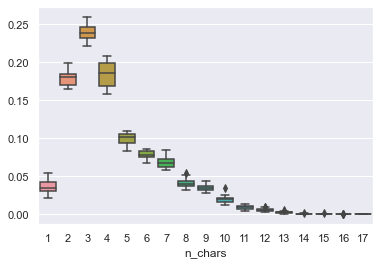

In [34]:
sns.boxplot(data=T2.loc[2]);

In [35]:
# sns.relplot?

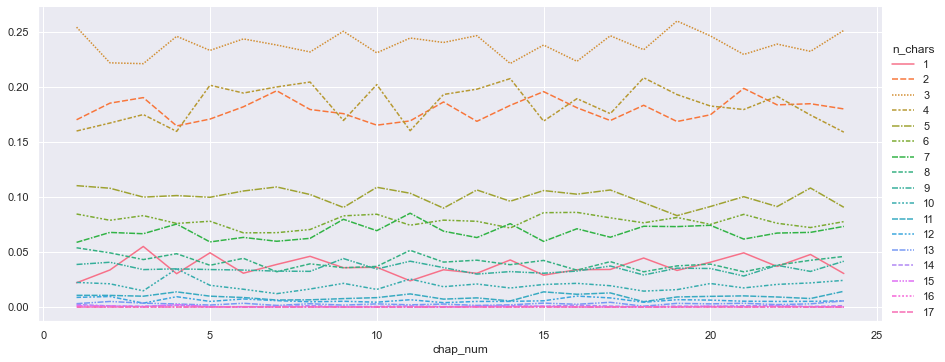

In [36]:
sns.relplot(data=T2.loc[2], kind='line', aspect=2.5);

<Figure size 432x288 with 0 Axes>

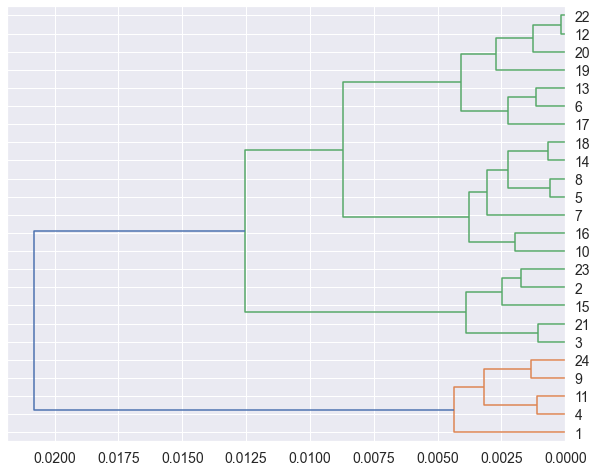

In [38]:
HAC(T2.loc[2]).plot();